# Amperon Data Engineering Take Home Assignment

In [1]:
from datetime import datetime, timedelta

import matplotlib.pyplot as plt
import pandas as pd
import psycopg

from tomorrow.database import get_postgres_kwargs

In [2]:
conn_kwargs = get_postgres_kwargs()
conn = psycopg.connect(**conn_kwargs)

## Question 1

What's the latest temperature for each geolocation? What's the latest wind speed?

In [3]:
query = """
WITH latest_data AS (
    SELECT 
        location_id,
        MAX(time) as max_time
    FROM weather
    WHERE is_forecast = FALSE
    GROUP BY location_id
)
SELECT 
    l.latitude,
    l.longitude,
    w.time,
    w.temperature,
    w.wind_speed
FROM weather w
JOIN location l 
    ON w.location_id = l.id
JOIN latest_data ld 
    ON w.location_id = ld.location_id 
    AND w.time = ld.max_time
WHERE w.is_forecast = FALSE
ORDER BY l.latitude, l.longitude
"""

with conn.cursor() as cur:
    cur.execute(query)
    results = cur.fetchall()

print("Latest temperature and wind speed for each geolocation:")
for row in results:
    print(f"Lat: {row[0]}, Lon: {row[1]}, Time: {row[2]}, Temperature: {row[3]}°C, Wind Speed: {row[4]} m/s")

Latest temperature and wind speed for each geolocation:
Lat: 25.8600, Lon: -97.4200, Time: 2024-10-13 22:00:00+00:00, Temperature: 29.19°C, Wind Speed: 3.81 m/s
Lat: 25.9000, Lon: -97.5200, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.63°C, Wind Speed: 3.69 m/s
Lat: 25.9000, Lon: -97.4800, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.31°C, Wind Speed: 3.63 m/s
Lat: 25.9000, Lon: -97.4400, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.0°C, Wind Speed: 3.69 m/s
Lat: 25.9000, Lon: -97.4000, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.0°C, Wind Speed: 3.88 m/s
Lat: 25.9200, Lon: -97.3800, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.0°C, Wind Speed: 3.88 m/s
Lat: 25.9400, Lon: -97.5400, Time: 2024-10-13 22:00:00+00:00, Temperature: 31.0°C, Wind Speed: 3.63 m/s
Lat: 25.9400, Lon: -97.5200, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.88°C, Wind Speed: 3.5 m/s
Lat: 25.9400, Lon: -97.4800, Time: 2024-10-13 22:00:00+00:00, Temperature: 30.88°C, Wind Speed: 3.5 m/s
Lat: 

## Question 2

Show an hourly time series of temperature (or any other available weather variable) from a day ago to 5 days in the future for a selected location.

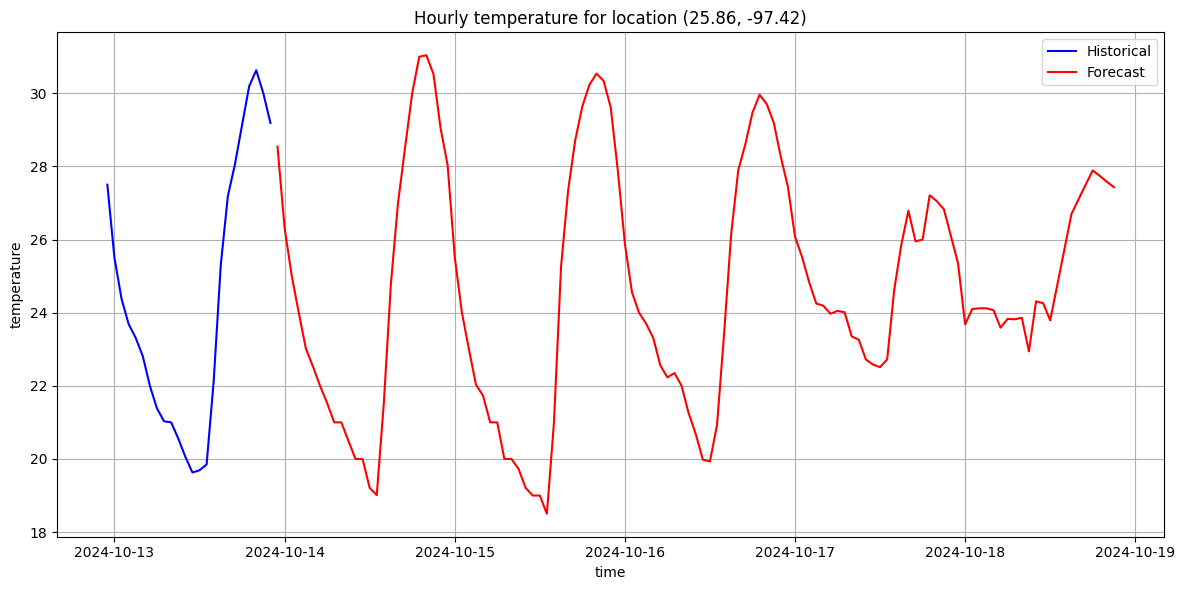

In [4]:
# Specify with the desired location ID
latitude = 25.8600
longitude = -97.4200

# Specify the weather variable (it must be a column name)
# Options include "wind_speed", "humidity", and "precipitation_probability"
weather_variable = "temperature"

# Specify the time range
end_time = datetime.now() + timedelta(days=5)
start_time = end_time - timedelta(days=6)

query = f"""
SELECT 
    w.time,
    w.{weather_variable} AS values,
    w.is_forecast
FROM weather w
JOIN location l
    ON w.location_id = l.id
WHERE l.latitude = %s
    AND l.longitude = %s
    AND time BETWEEN %s AND %s
ORDER BY time
"""

with conn.cursor() as cur:
    cur.execute(query, (latitude, longitude, start_time, end_time))
    results = cur.fetchall()

# Convert results to a pandas DataFrame
df = pd.DataFrame(results, columns=['time', weather_variable, 'is_forecast'])
historical = df[~df['is_forecast']]
forecast = df[df['is_forecast']]

# Plot the time series
plt.figure(figsize=(12, 6))
plt.plot(historical['time'], historical[weather_variable], color='blue', label='Historical')
plt.plot(forecast['time'], forecast[weather_variable], color='red', label='Forecast')
plt.title(f'Hourly {weather_variable} for location ({latitude}, {longitude})')
plt.xlabel('time')
plt.ylabel(weather_variable)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [5]:
conn.close()